# Distilling a Neural Network into Soft Decision Tree

* Implementation based on [[Frosst & Hinton, 2017](http://arxiv.org/abs/1711.09784)]

## Imports

In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from models import ConvNet, SoftBinaryDecisionTree
from models.utils import brand_new_tfsession, draw_tree
from tensorflow.keras.callbacks import EarlyStopping, Callback

sess = brand_new_tfsession()

/home/mizzou/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mizzou/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mizzou/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mizzou/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

## Dataset

In [2]:
x = np.load('recurrence.npy')
y = np.load('recurrence_labs.npy')

In [3]:
import pandas as pd
y_cat = pd.Categorical(y)
y = y_cat.codes

Text(0.5, 1.0, 'label: 0')

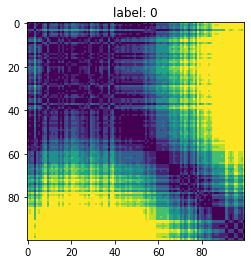

In [4]:
plt.imshow(x[105,:,:])
plt.title('label: {}'.format(y[105]))

In [5]:
n_train = int(0.8*x.shape[0])
x_train = x[0:n_train,:]
y_train = y[0:n_train]
x_test = x[n_train:,:]
y_test = y[n_train:]

# add channel dim
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

# hold out last 10% of training samples for validation
n_valid = int(0.1*x_train.shape[0])
x_valid, y_valid = x_train[-n_valid:], y_train[-n_valid:]
x_train, y_train = x_train[:-n_valid], y_train[:-n_valid]

print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape)

(720, 100, 100, 1) (720,) (80, 100, 100, 1) (80,) (200, 100, 100, 1) (200,)


In [6]:
# load MNIST data
#mnist = tf.keras.datasets.mnist
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

# add channel dim
#x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

# hold out last 10000 training samples for validation
#x_valid, y_valid = x_train[-10000:], y_train[-10000:]
#x_train, y_train = x_train[:-10000], y_train[:-10000]

#print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape)

In [7]:
# retrieve image and label shapes from training data
img_rows, img_cols, img_chans = x_train.shape[1:]
n_classes = np.unique(y_train).shape[0]

print(img_rows, img_cols, img_chans, n_classes)

100 100 1 10


In [8]:
# convert labels to 1-hot vectors
y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, n_classes)
y_test = tf.keras.utils.to_categorical(y_test, n_classes)

print(y_train.shape, y_valid.shape, y_test.shape)

(720, 10) (80, 10) (200, 10)


In [9]:
# normalize inputs and cast to float
x_train = (x_train / np.max(x_train)).astype(np.float32)
x_valid = (x_valid / np.max(x_valid)).astype(np.float32)
x_test = (x_test / np.max(x_test)).astype(np.float32)

## Neural Network

In [10]:
nn = ConvNet(img_rows, img_cols, img_chans, n_classes)
nn.maybe_train(data_train=(x_train, y_train),
               data_valid=(x_valid, y_valid),
               batch_size=16, epochs=2)
nn.evaluate(x_train, y_train)

No checkpoint found on assets/nn-model.hdf5. Training from scratch.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 720 samples, validate on 80 samples
Epoch 1/2
720/720 [==============================] - 46s 64ms/sample - loss: 1.6025 - acc: 0.5181 - val_loss: 0.2648 - val_acc: 0.9875
Epoch 2/2
720/720 [==============================] - 52s 72ms/sample - loss: 0.4354 - acc: 0.8639 - val_loss: 0.0341 - val_acc: 1.0000
Saving trained model to assets/nn-model.hdf5.
720/720 [==============================] - 7s 10ms/sample - loss: 0.0347 - acc: 1.0000
accuracy: 100.00% | loss: 0.03471077109376589


In [11]:
nn.evaluate(x_valid, y_valid)
nn.evaluate(x_test, y_test)

80/80 [==============================] - 1s 11ms/sample - loss: 0.0341 - acc: 1.0000
accuracy: 100.00% | loss: 0.03408110663294792
200/200 [==============================] - 2s 9ms/sample - loss: 0.0408 - acc: 1.0000
accuracy: 100.00% | loss: 0.04079749703407288


### Extraction of soft labels for distillation

In [12]:
y_train_soft = nn.predict(x_train)
y_train_soft.shape

720/720 [==============================] - 7s 10ms/sample


(720, 10)

## Binary Soft Decision Tree

Flatten dataset in advance

In [13]:
x_train_flat = x_train.reshape((x_train.shape[0], -1))
x_valid_flat = x_valid.reshape((x_valid.shape[0], -1))
x_test_flat = x_test.reshape((x_test.shape[0], -1))

# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.imshow(x_test_flat.reshape((x_test_flat.shape[0], img_rows, img_cols))[1])

x_train_flat.shape, x_valid_flat.shape, x_test_flat.shape

((720, 10000), (80, 10000), (200, 10000))

### Hyperparameters
* `tree_depth`: as denoted in the [[paper](https://arxiv.org/pdf/1711.09784.pdf)], depth is in terms of inner nodes (excluding leaves / indexing depth from `0`)
* `penalty_strength`: regularization penalty strength
* `penalty_decay`: regularization penalty decay: paper authors found 0.5 optimal (note that $2^{-d} = 0.5^d$ as we use it)
* `ema_win_size`: scaling factor to the "default size of the window" used to calculate moving averages (growing exponentially with depth) of node and path probabilities
* `inv_temp`: scale logits of inner nodes to "avoid very soft decisions" [[paper](https://arxiv.org/pdf/1711.09784.pdf)]
    * pass `0` to indicate that this should be a learned parameter (single scalar learned to apply to all nodes in the tree)
* `learning_rate`: hopefully no need to explain, but let's be cool and use [Karpathy constant](https://www.urbandictionary.com/define.php?term=Karpathy%20Constant) ([source](https://twitter.com/karpathy/status/801621764144971776)) :D as default in `tree.__init__()`
* `batch_size`: we use a small one, because with increasing depth and thus amount of leaf bigots, larger batch sizes cause their loss terms to be scaled down too much by averaging, which results in poor optimization properties

In [14]:
n_features = img_rows * img_cols * img_chans
tree_depth = 4
penalty_strength = 1e+1
penalty_decay = 0.25
ema_win_size = 1000
inv_temp = 0.01
learning_rate = 5e-03
batch_size = 4

### Regular training with hard labels

In [15]:
sess = brand_new_tfsession(sess)

tree = SoftBinaryDecisionTree(tree_depth, n_features, n_classes,
    penalty_strength=penalty_strength, penalty_decay=penalty_decay,
    inv_temp=inv_temp, ema_win_size=ema_win_size, learning_rate=learning_rate)
tree.build_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Built tree has 16 leaves out of 31 nodes


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [16]:
epochs = 40

es = EarlyStopping(monitor='val_acc', patience=5, verbose=1)

'''If you wish to train your own model instead of loading one from checkpoint, remove the checkpoint.'''
#os.remove('assets/non-distilled/checkpoint')
#for f in glob.glob('assets/non-distilled/tree-model*'):
    #os.remove(f)

tree.maybe_train(
    sess=sess, data_train=(x_train_flat, y_train), data_valid=(x_valid_flat, y_valid),
    batch_size=batch_size, epochs=epochs, callbacks=[es])

Loading trained model from assets/non-distilled/tree-model.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
assets/non-distilled/tree-model is not a valid checkpoint. Training from scratch.
Train on 720 samples, validate on 80 samples
Epoch 1/40
720/720 [==============================] - 13s 18ms/sample - loss: 16.1434 - acc: 0.1000 - val_loss: 9.2609 - val_acc: 0.0625
Epoch 2/40
720/720 [==============================] - 6s 9ms/sample - loss: 8.4132 - acc: 0.1542 - val_loss: 7.6734 - val_acc: 0.1000
Epoch 3/40
720/720 [==============================] - 7s 10ms/sample - loss: 7.8167 - acc: 0.3028 - val_loss: 8.1742 - val_acc: 0.4375
Epoch 4/40
720/720 [==============================] - 7s 9ms/sample - loss: 8.6653 - acc: 0.4375 - val_loss: 9.2712 - val_acc: 0.4875
Epoch 5/40
720/720 [==============================] - 8s 11ms/sample - loss: 9.7696 - acc: 0.4875 - val_loss: 10.4218 - val_acc: 0.4875
Epoch 6/40
720/720 [==============================

In [17]:
tree.evaluate(x=x_valid_flat, y=y_valid, batch_size=batch_size)
tree.evaluate(x=x_test_flat, y=y_test, batch_size=batch_size)

80/80 [==============================] - 0s 4ms/sample - loss: 12.8563 - acc: 0.4375
accuracy: 43.75% | loss: 12.856304550170899
200/200 [==============================] - 1s 4ms/sample - loss: 12.9098 - acc: 0.4850
accuracy: 48.50% | loss: 12.909763088226319


### Distillation: training with soft labels

In [18]:
sess = brand_new_tfsession(sess)

tree = SoftBinaryDecisionTree(tree_depth, n_features, n_classes,
    penalty_strength=penalty_strength, penalty_decay=penalty_decay,
    inv_temp=inv_temp, ema_win_size=ema_win_size, learning_rate=learning_rate)
tree.build_model()

Built tree has 16 leaves out of 31 nodes


In [19]:
epochs = 40

es = EarlyStopping(monitor='val_acc', patience=5, verbose=1)

'''If you wish to train your own model instead of loading one from checkpoint, remove the checkpoint.'''
# os.remove('assets/distilled/checkpoint')
# for f in glob.glob('assets/distilled/tree-model*'):
#     os.remove(f)

tree.maybe_train(
    sess=sess, data_train=(x_train_flat, y_train_soft), data_valid=(x_valid_flat, y_valid),
    batch_size=batch_size, epochs=epochs, callbacks=[es], distill=True)

Loading trained model from assets/distilled/tree-model.
assets/distilled/tree-model is not a valid checkpoint. Training from scratch.
Train on 720 samples, validate on 80 samples


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f1781055be0>>
Traceback (most recent call last):
  File "/home/mizzou/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Epoch 1/40
720/720 [==============================] - 11s 15ms/sample - loss: 15.6391 - acc: 0.1000 - val_loss: 8.6038 - val_acc: 0.1375
Epoch 2/40
720/720 [==============================] - 6s 9ms/sample - loss: 8.3253 - acc: 0.1847 - val_loss: 8.2765 - val_acc: 0.3875
Epoch 3/40
720/720 [==============================] - 7s 9ms/sample - loss: 8.5276 - acc: 0.4069 - val_loss: 8.8665 - val_acc: 0.6750
Epoch 4/40
720/720 [==============================] - 7s 9ms/sample - loss: 9.3398 - acc: 0.5792 - val_loss: 9.8927 - val_acc: 0.6500
Epoch 5/40
720/720 [==============================] - 7s 10ms/sample - loss: 10.4989 - acc: 0.6486 - val_loss: 11.1376 - val_acc: 0.7125
Epoch 6/40
720/720 [==============================] - 7s 10ms/sample - loss: 11.8518 - acc: 0.6806 - val_loss: 12.4810 - val_acc: 0.7375
Epoch 7/40
720/720 [==============================] - 6s 9ms/sample - loss: 13.1798 - acc: 0.6889 - val_loss: 13.9439 - val_acc: 0.7375
Epoch 8/40
720/720 [==============================]

In [20]:
tree.evaluate(x=x_valid_flat, y=y_valid, batch_size=batch_size)
tree.evaluate(x=x_test_flat, y=y_test, batch_size=batch_size)

80/80 [==============================] - 0s 5ms/sample - loss: 16.7280 - acc: 0.6875
accuracy: 68.75% | loss: 16.727973461151123
200/200 [==============================] - 1s 4ms/sample - loss: 16.9987 - acc: 0.7000
accuracy: 70.00% | loss: 16.998733654022217


### Visualizing learned parameters

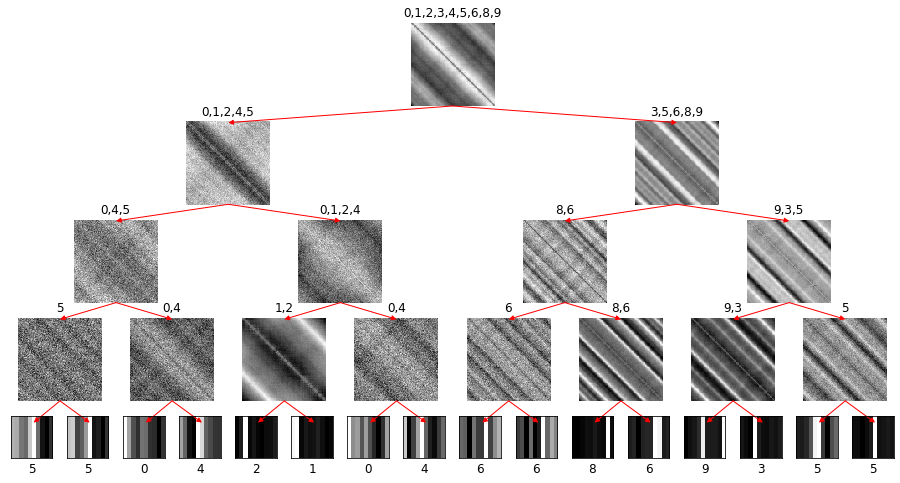

In [21]:
draw_tree(sess, tree, img_rows, img_cols, img_chans)
plt.show()

#### How to read the visual

Exactly as in the [[paper](https://arxiv.org/pdf/1711.09784.pdf)]:
* Number **below** any **leaf** denotes `argmax()` of learned distribution, thus final static **prediction** of the (bigot, not expert!) leaf.
* Numbers **above** any **inner node** denote the **set of possible predictions** in the sub-tree of the given node.

### Visualizing decision path

In [22]:
digit = 9

# get (reproducibly) pseudo-random example of chosen digit
np.random.seed(0)
sample_index = np.random.choice(np.where(np.argmax(y_test, axis=1)==digit)[0])
input_img = x_test[sample_index]

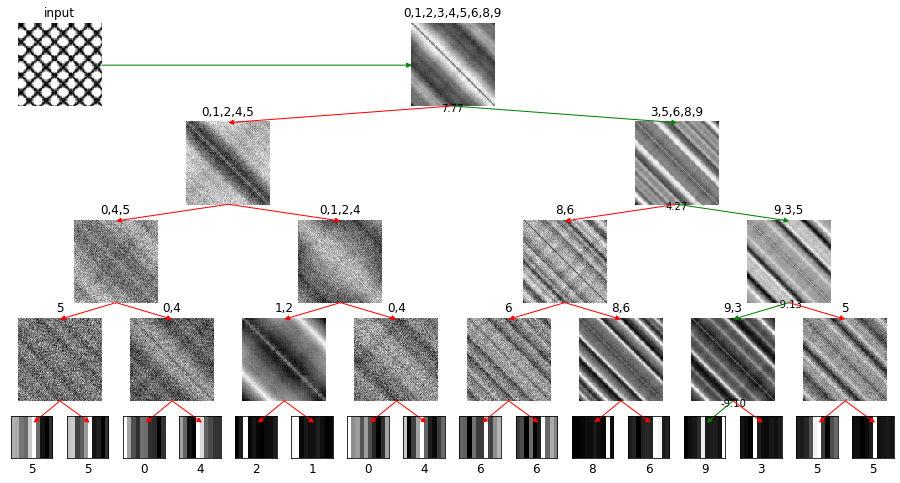

In [23]:
draw_tree(sess, tree, img_rows, img_cols, img_chans, input_img=input_img)

#### How to read the visual

* The <span style="color:green">**maximum probability path**</span> leading **to final prediction** is now denoted by <span style="color:green"> **green arrows**</span>
* Number **below** any given **inner node** on this <span style="color:green">**path**</span> denotes the **pre-activation logit** $ = (\beta (\mathbf{xw}_i + b_i))$.
    * This is basically just a **biased** ($b_i$) and **scaled** ($\beta$) **correlation** of **input** ($\mathbf{x}$) with the given **mask** ($\mathbf{w}_i$).
    * From the definition of $\sigma$ activation function, the choice of branch breaks around `0`.
    * From the definition of **branching** in the [[paper](https://arxiv.org/pdf/1711.09784.pdf)], **negative** correlations branch **to the left**, while **positive** correlations branch **to the right**.

<img src="assets/img/branching.png" width="35%"/>

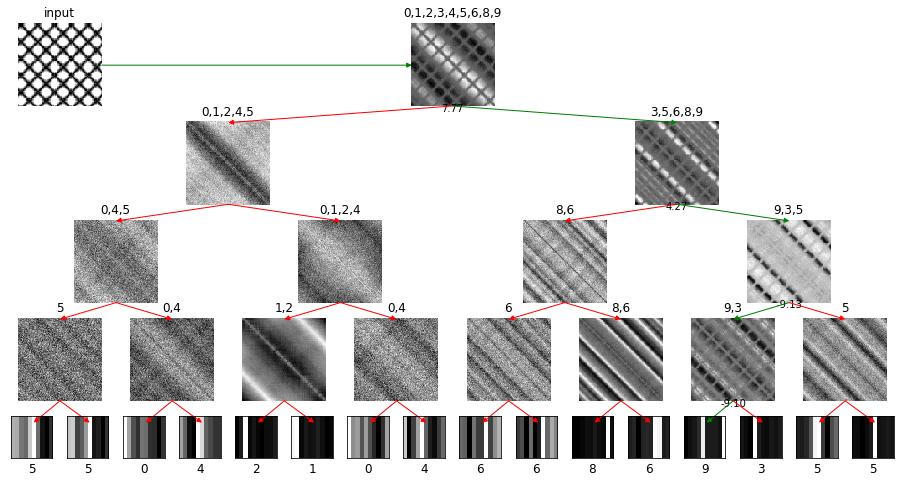

In [24]:
draw_tree(sess, tree, img_rows, img_cols, img_chans, input_img=input_img, show_correlation=True)

#### How to read the visual

* On the <span style="color:green">**maximum probability path**</span> there are now **correlations** of the **input image** with the **node masks**.
* The **homogeneous area** gives a frame of reference for color of `0`s.
    * It always corresponds to the **black area in the input image**, but due to lack of normalization (yes, I'm the lazy one here), it ends up as different shade of gray in each subplot.
    * All **lighter pixels** from this correspond to **positive correlation coefficients**.
    * All **darker pixels** correspond to **negative correlation coefficients**.

_Note: In the last input-masked kernel on the path to prediction, notice how model recognizes `9`s from `7`s._

To save the inference example as animation, run the cell below.

In [25]:
if not os.path.isdir('assets/img/infer'):
    os.mkdir('assets/img/infer')

draw_tree(sess, tree, img_rows, img_cols, img_chans,
          input_img=input_img,
          savepath='assets/img/infer/0.png')
draw_tree(sess, tree, img_rows, img_cols, img_chans,
          input_img=input_img, show_correlation=True,
          savepath='assets/img/infer/1.png')

!convert -delay 100 -loop 0 assets/img/infer/*.png assets/img/infer.gif

### Capturing the progress of learning

In [26]:
if not os.path.isdir('assets/img/epoch'):
    os.mkdir('assets/img/epoch')

if not os.path.isdir('assets/img/sample'):
    os.mkdir('assets/img/sample')

In [27]:
sess = brand_new_tfsession(sess)

tree = SoftBinaryDecisionTree(tree_depth, n_features, n_classes,
    penalty_strength=penalty_strength, penalty_decay=penalty_decay,
    inv_temp=inv_temp, ema_win_size=ema_win_size, learning_rate=learning_rate)
tree.build_model()

tree.initialize_variables(sess, x_train_flat, batch_size)

Built tree has 16 leaves out of 31 nodes


In [ ]:
class ModelImageSaver(Callback):
    def __init__(self, display, limit):
        self.seen = 0
        self.display = display
        self.limit = limit
        
    def on_train_begin(self, logs={}):
        draw_tree(sess, tree, img_rows, img_cols, img_chans,
                  savepath='assets/img/epoch/{:04}.png'.format(0))
        draw_tree(sess, tree, img_rows, img_cols, img_chans,
                  savepath='assets/img/sample/{:07}.png'.format(0))
        
    def on_epoch_end(self, epoch, logs={}):
        draw_tree(sess, tree, img_rows, img_cols, img_chans,
                  savepath='assets/img/epoch/{:04}.png'.format(epoch+1))

    def on_batch_end(self, batch, logs={}):
        self.seen += logs.get('size', 0)
        if self.seen % self.display == 0 and self.seen <= self.limit:
            draw_tree(sess, tree, img_rows, img_cols, img_chans,
                      savepath='assets/img/sample/{:07}.png'.format(self.seen))

image_saver = ModelImageSaver(1000, 250000)
# save image after each 1000th training example
# save max 250 images (corresponds to first 5 training epochs)

tree.model.fit(x=x_train_flat, y=y_train_soft, validation_data=(x_valid_flat, y_valid),
               batch_size=batch_size, epochs=40, callbacks=[image_saver]);

Train on 720 samples, validate on 80 samples
Epoch 1/40
712/720 [============================>.] - ETA: 0s - loss: 20.9296 - acc: 0.0871

#### Compiling snapshots into animation
**Note**: converting captured series of PNG images into a GIF animation with `makegif.sh` requires `bash` environment with `convert` CLI tool available.

##### Epoch-wise compilation

In [ ]:
!./makegif.sh epoch

![epoch.gif](assets/img/epoch.gif)

##### Sample-wise compilation

In [ ]:
!./makegif.sh sample

![sample.gif](assets/img/sample.gif)

## Elaborating

![deeper.jpg](assets/img/deeper.jpg)

By now, you should know what's coming...

In [ ]:
tree_depth = 5

In [ ]:
sess = brand_new_tfsession(sess)

tree = SoftBinaryDecisionTree(tree_depth, n_features, n_classes,
    penalty_strength=penalty_strength, penalty_decay=penalty_decay,
    inv_temp=inv_temp, ema_win_size=ema_win_size, learning_rate=learning_rate)
tree.build_model()

tree.initialize_variables(sess, x_train_flat, batch_size)

In [ ]:
tree.model.fit(x=x_train_flat, y=y_train_soft, validation_data=(x_valid_flat, y_valid),
               batch_size=batch_size, epochs=3);

# os.mkdir('assets/depth-{}'.format(tree_depth))
# tree.save_variables(sess, 'assets/depth-{}/tree-model'.format(tree_depth))

In [ ]:
draw_tree(sess, tree, img_rows, img_cols, img_chans)

Sorry, but deeper than this was not so visually appealing and would take much longer to train to a reasonable performance to even motivate examination.

# Final word

If you're reading this, I believe you are interested in this implementation, so please don't hesitate to **try it yourself** :)

* tune hyperparameters of the tree model
    * try out different depths and penalty parameters (strength, decay)
    * implement dynamic inverse temperature ($\beta$), scheduled as a function of training step / epoch
* try out different dataset, the approach is generic enough!

If you get any interesting results with this implementation, feel free to share them as an [issue](https://github.com/lmartak/distill-nn-tree/issues). Also feel free to improve this repo by submitting a [PR](https://github.com/lmartak/distill-nn-tree/pulls) or just making your own [fork](https://github.com/lmartak/distill-nn-tree/network/members).


If you feel adventurous, you could try:
* improve `draw_tree`'s correlation mode by normalizing the shade of gray around fixed-`0` color shade
* add similar notebook with whole training, distillation & evaluation lifecycle on different dataset (e.g. `cifar-10.ipynb` for [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset)
    * This would probably require colorful masks and some experimenting with their normalization for the purposes of visualization, but could be fun!